In [261]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
import xgboost as xgb


%matplotlib inline
plt.style.use('ggplot')

In [309]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv").drop("Unnamed: 0", axis=1)
train_target = pd.read_csv("train_target.csv")
print("Shapes of data: train_data - {}, test_data - {}, train_target - {}".format(train_data.shape, test_data.shape, train_target.shape))
print("Proportion train/test: ", int(train_data.shape[0]/test_data.shape[0]))

Shapes of data: train_data - (27595, 20), test_data - (13593, 20), train_target - (27595, 1)
Proportion train/test:  2


In [250]:
cat_cols = ["job", "marital", "education", "default",
            "housing", "loan", "contact", "month", "day_of_week", "poutcome"]


In [ ]:
yes_indexes = train_target[train_target["1"]==1].index
no_indexes = train_target[train_target["1"]==0].index

In [264]:
print('Is everything ok?: ',  train_data.shape[0] == train_target.shape[0])

Is everything ok?:  True


In [72]:
new_train_yes = train_data.iloc[yes_indexes]
new_train_no = train_data.iloc[no_indexes][:int(1.5*len(new_train_yes))]
us_train = pd.concat([new_train_yes, new_train_no], axis=0).reset_index(drop=True)

new_train_target_yes = train_target.iloc[new_train_yes.index]
new_train_target_no = train_target.iloc[new_train_no.index]
us_target = pd.concat([new_train_target_yes, new_train_target_no], axis=0).reset_index(drop=True)
us_target.columns=["target"]

In [251]:
seed = 34791

### Preprocessing

In [269]:
from pandas import get_dummies
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

In [1]:
def preprocess_target(target):
    return np.array(train_target).reshape(train_target.shape[0],)

def preproces(data):
    
    categorical_cols = ["job", "marital", "education", "default",
            "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
    
    cat_data = pd.get_dummies(data[categorical_cols])
    print("1HotEncoded shape: ", cat_data.shape)
    
    num_data = data.drop(categorical_cols, axis=1)
    
    num_data = pd.DataFrame(MinMaxScaler().fit_transform(num_data), columns = num_data.columns)

    return pd.concat([cat_data, num_data], axis=1).drop(['previous'], axis = 1)

### Undersampling

In [271]:
from imblearn.under_sampling import RandomUnderSampler

In [272]:
def undersample(data, target):
    random_us = RandomUnderSampler(random_state=seed)
    data_, target_ = random_us.fit_sample(data, target['target'].values.ravel())
    return pd.DataFrame(data_, columns=data.columns), pd.DataFrame(target_, columns=target.columns)

In [310]:
scaled_train = preproces(train_data)

In [302]:
us_scaled_data, us_target = undersample(scaled_train, train_target)

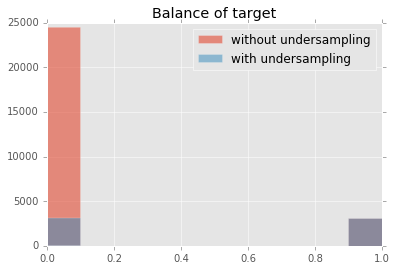

In [275]:
plt.title("Balance of target")
plt.hist(train_target.values.ravel(),alpha=0.6, label = "without undersampling")
plt.hist(us_target.values.ravel(), alpha=0.5, label = "with undersampling")
plt.legend()

### t-SNE

In [192]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [194]:
tsne = TSNE(n_jobs=4)
train_tsne = tsne.fit_transform(np.array(us_scaled_data))

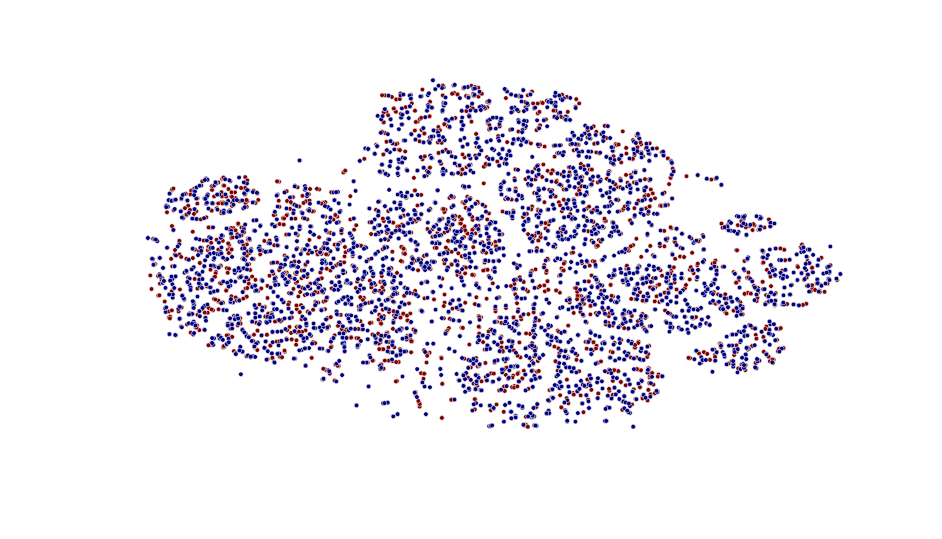

In [195]:
plt.figure(figsize=(16, 9))
plt.scatter(train_tsne[:,0], train_tsne[:,1], c = np.array(us_scaled_target))
ax = plt.axis('off')

### FS with RF

In [196]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [197]:
def get_features_rf(data, target, select_model):
    for_seleсt = select_model.fit(data, target)
    model = SelectFromModel(for_seleсt, prefit=True)
    selected_train = model.transform(data)
    print("Old shape: {}, new shape: {}".format(data.shape, selected_train.shape))
    return selected_train

### SVC

In [208]:
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC, OneClassSVM, LinearSVC
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [199]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [200]:
def train_cv_lsvm(data, target, folds=5):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state =442, stratify=target)
    
    C_range = np.logspace(-2, 5, 3)
    gamma_range = np.logspace(-9, 3, 5)
    svm_grid = {'C': C_range, 
                'gamma': gamma_range}
    
    svm_grid= GridSearchCV(SVC(kernel='rbf', probability=True), param_grid=svm_grid, cv=folds, n_jobs=4, verbose=2)
    svm_grid.fit(X_train, y_train)
    
    predictions = svm_grid.best_estimator_.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1], pos_label=1)
    print("AUC : %.4g" % auc(fpr, tpr))
    
    for params, mean_score, scores in svm_grid.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    

    scores = [x[1] for x in svm_grid.grid_scores_]
    scores = np.array(scores).reshape(len(C_range), len(gamma_range))
    
    plt.figure(figsize = (9,9))
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('$\gamma$', fontsize="xx-large")
    plt.ylabel('$C$', rotation=0, fontsize="xx-large")
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=0)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')
    plt.show()
    
def lsvm(data, target):
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,
                                                        random_state =442, stratify=target)
    
    svm = LinearSVC(C=15,class_weight='balanced')
    svm.fit(X_train, y_train)
    
    predictions = svm.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
    print("AUC : %.4g" % auc(fpr, tpr))

In [ ]:
fs_train = get_features_rf(proc_train, train_target, RandomForestClassifier())

In [ ]:
train_cv_lsvm(fs_train, np.array(train_target).ravel())

### xgb

In [276]:
def xgb_best_params(data, target):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=442, stratify=target)
    skf = StratifiedKFold(target, n_folds=5, random_state=42)
    
    gbm = xgb.XGBClassifier(max_features=4, max_depth=5, learning_rate=0.075, n_estimators=1200,
                            min_child_weight=4, gamma=0.2, subsample=0.8,
                            colsample_bytree=0.8, scale_pos_weight=2, nthread=3)
    """for train_index, test_index in skf:
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]"""
    
    
    results = cross_val_score(gbm, data, target, cv=skf, scoring='roc_auc')
    print("AUC ROC on folds: %.4f%% ", results)
    print("AUC ROC mean: %.4f%% (%.4f%%)" % (results.mean()*100, results.std()*100))
    
    gbm.fit(X_train, y_train, eval_metric = 'auc')
    
    predictions = gbm.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:, 1], pos_label=1)
    print("AUC : %.4g" % auc(fpr, tpr))
    
    
'max_depth': 5, 'learning_rate': 0.075, 'objective': 'rank:pairwise', 'n_estimators': 150
    

In [312]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, train_target.values, test_size=0.25, 
                 random_state = seed, stratify=us_target["target"].values)

In [ ]:
'max_depth': 5, 'learning_rate': 0.075, 'objective': 'rank:pairwise', 'n_estimators': 150

In [313]:
gbm = xgb.XGBClassifier(max_depth=5, learning_rate=0.03, n_estimators=1200,
                            min_child_weight=4, gamma=0.2, subsample=0.8,
                            colsample_bytree=0.8, scale_pos_weight=2, nthread=3)

gbm.fit(X_train, y_train);

    
y_predicted = gbm.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predicted[:, 1], pos_label=1)
print("AUC : %.4g" % auc(fpr, tpr))
#print('Score on test sample:', roc_auc_score(y_test, y_predicted))



/home/rudolph/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/rudolph/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC : 0.949


In [283]:
y_predicted

array([[  5.51724434e-03,   9.94482756e-01],
       [  5.03122091e-01,   4.96877909e-01],
       [  8.60431194e-02,   9.13956881e-01],
       ..., 
       [  9.99781668e-01,   2.18320100e-04],
       [  9.98408556e-01,   1.59144565e-03],
       [  9.97431397e-01,   2.56860699e-03]], dtype=float32)

In [284]:
def write_to_submission_file(predicted_labels, out_file='output.csv',
                             target='Prediction', index_label="Id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [288]:
write_to_submission_file(y_predicted[:, 0])

In [315]:
test_data = convert_features(test_data)

In [316]:
y_predicted = gbm.predict_proba(test_data)
write_to_submission_file(y_predicted[:, 1])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def ensemble(data, target):

    np.random.seed(0)  # seed to shuffle the train set
    n_folds = 10
    verbose = True
    shuffle = False

    X, y, = np.array(data), np.array(target).ravel()
    X, x_test, y, y_test_ = train_test_split(X, y, test_size=0.2, stratify=y)
    
    skf = list(StratifiedKFold(y, n_folds))

    clfs = [RandomForestClassifier(n_estimators=450, n_jobs=3, criterion='gini'), 
            RandomForestClassifier(n_estimators=450, n_jobs=3, criterion='entropy'), 
            ExtraTreesClassifier(n_estimators=450, n_jobs=3, criterion='gini'), 
            ExtraTreesClassifier(n_estimators=450, n_jobs=3, criterion='entropy'), 
            xgb.XGBClassifier(max_depth=5, learning_rate=0.03, n_estimators=450, 
                              min_child_weight=1, gamma=0.2, subsample=0.8, 
                              colsample_bytree=0.6, reg_alpha=0.01, scale_pos_weight=7, nthread=3)]

    print("Creating train and test sets for blending.")

    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((x_test.shape[0], len(clfs)))

    for j, clf in enumerate(clfs):
        print(j, clf)
        dataset_blend_test_j = np.zeros((x_test.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            print("Fold", i)
            X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(X_test)[:, 1]
            dataset_blend_train[test, j] = y_pred
            dataset_blend_test_j[:, i] = clf.predict(x_test)
        dataset_blend_test[:,j] = dataset_blend_test_j.mean(1)
    
    #print(dataset_blend_train)
    print("Blending")
    clf = LogisticRegression()
    clf.fit(dataset_blend_train, y)
    
    predictions = clf.predict_proba(dataset_blend_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
    print("AUC : %.4g" % auc(fpr, tpr))
    